In [1]:
# ===============================================================
# STEP 1: Import Libraries & Set Configurations
# ===============================================================
import os
import sys
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# --- Set seeds for reproducibility ---
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Libraries successfully imported.")
print("TensorFlow version:", tf.__version__)

# --- Base configurations ---
BASE_PATH = "/kaggle/input/solar-plate-image"  # Change if needed
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 30

2025-11-15 05:51:26.540960: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763185886.789730      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763185886.857368      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

✅ Libraries successfully imported.
TensorFlow version: 2.18.0


In [2]:
# ===============================================================
# STEP 2: Verify Dataset Paths
# ===============================================================
physical_dir = os.path.join(BASE_PATH, "Physical data")

print("🔍 Checking dataset directories...")
if not os.path.exists(BASE_PATH):
    raise FileNotFoundError(f"❌ Base path not found: {BASE_PATH}\n➡️ Upload dataset or check path.")

if not os.path.exists(physical_dir):
    raise FileNotFoundError(f"❌ 'Physical data' folder not found inside {BASE_PATH}\n➡️ Check folder name or capitalization.")

print("✅ Dataset paths verified successfully.")
print("Physical Data Directory:", physical_dir)


🔍 Checking dataset directories...
✅ Dataset paths verified successfully.
Physical Data Directory: /kaggle/input/solar-plate-image/Physical data


In [3]:
# ===============================================================
# STEP 3: Load Physical Data Function
# ===============================================================
def load_physical_data(base_path, img_size=(224,224)):
    """
    Loads all images from 'Physical data' subfolders, resizes, normalizes,
    and labels them automatically.
    """
    physical_path = os.path.join(base_path, "Physical data")
    class_dirs = sorted([d for d in os.listdir(physical_path) if os.path.isdir(os.path.join(physical_path, d))])
    
    if len(class_dirs) == 0:
        raise RuntimeError(f"❌ No class folders found in {physical_path}.")
    
    print(f"✅ Found class folders: {class_dirs}")
    images, labels = [], []
    class_dict = {c:i for i, c in enumerate(class_dirs)}

    for c in class_dirs:
        folder = os.path.join(physical_path, c)
        files = []
        for ext in ('*.jpg','*.jpeg','*.png'):
            files.extend(glob.glob(os.path.join(folder, ext)))
        if len(files) == 0:
            print(f"⚠️ No images in folder: {folder}")
            continue

        print(f"📂 Loading {len(files)} images from '{c}'...")
        for f in files:
            try:
                img = cv2.imread(f)
                if img is None:
                    print(f"⚠️ Skipping unreadable file: {f}")
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                img = img.astype('float32') / 255.0
                images.append(img)
                labels.append(class_dict[c])
            except Exception as e:
                print(f"❌ Error reading {f}: {e}")

    if len(images) == 0:
        raise RuntimeError("❌ No images loaded. Check dataset format.")
    
    print(f"✅ Loaded {len(images)} images across {len(class_dirs)} classes.")
    return np.array(images), np.array(labels), class_dirs


In [4]:
# ===============================================================
# STEP 4: Run Loader and Basic Checks
# ===============================================================
X, y, class_names = load_physical_data(BASE_PATH, img_size=IMG_SIZE)

print("\n📊 Dataset Summary:")
print("Images shape:", X.shape)
print("Labels shape:", y.shape)
print("Classes:", class_names)

# Validate data
assert X.ndim == 4 and X.shape[-1] == 3, "❌ Images must be (N,H,W,3)"
print("✅ Data shape verified.")


✅ Found class folders: ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']
📂 Loading 171 images from 'Bird-drop'...
📂 Loading 185 images from 'Clean'...
📂 Loading 190 images from 'Dusty'...
📂 Loading 90 images from 'Electrical-damage'...
📂 Loading 66 images from 'Physical-Damage'...
📂 Loading 105 images from 'Snow-Covered'...
✅ Loaded 807 images across 6 classes.

📊 Dataset Summary:
Images shape: (807, 224, 224, 3)
Labels shape: (807,)
Classes: ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']
✅ Data shape verified.


In [5]:
# ===============================================================
# STEP 5: Split Data (Train / Validation / Test)
# ===============================================================
num_classes = len(class_names)
y_onehot = to_categorical(y, num_classes=num_classes)

X_train, X_temp, y_train, y_temp = train_test_split(X, y_onehot, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=np.argmax(y_temp, axis=1)
)

print("✅ Data successfully split.")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")


✅ Data successfully split.
Training set: (564, 224, 224, 3)
Validation set: (121, 224, 224, 3)
Test set: (122, 224, 224, 3)


In [6]:
# ===============================================================
# STEP 6: Build Transfer Learning Model 
# ===============================================================
def build_vgg16_model(input_shape, num_classes, use_imagenet=True):
    weights = 'imagenet' if use_imagenet else None
    try:
        base = VGG16(weights=weights, include_top=False, input_shape=input_shape)
        print("✅ Loaded best model with ImageNet weights.")
    except Exception as e:
        print("⚠️ Failed to load ImageNet weights. Using random initialization.")
        print("Error:", e)
        base = VGG16(weights=None, include_top=False, input_shape=input_shape)

    for layer in base.layers[:10]:
        layer.trainable = False

    x = base.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=out)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_vgg16_model((IMG_SIZE[0], IMG_SIZE[1], 3), num_classes)
model.summary()


2025-11-15 05:52:11.549699: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
✅ Loaded best model with ImageNet weights.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 27,696,198 (105.65 MB)

 Trainable params: 25,959,174 (99.03 MB)

 Non-trainable params: 1,737,024 (6.63 MB)

In [7]:
# ===============================================================
# STEP 7: Train Model with Callbacks
# ===============================================================
def train_model(model, X_train, y_train, X_val, y_val, batch_size=16, epochs=30):
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    ckpt = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
    es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1)
    rlrop = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1)

    print(f"🚀 Starting training: {len(X_train)} samples, batch size={batch_size}, epochs={epochs}")
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=batch_size),
        validation_data=(X_val, y_val),
        epochs=epochs,
        callbacks=[ckpt, es, rlrop],
        verbose=1
    )
    return history

history = train_model(model, X_train, y_train, X_val, y_val, BATCH_SIZE, EPOCHS)

🚀 Starting training: 564 samples, batch size=16, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2154 - loss: 2.4757
Epoch 1: val_accuracy improved from -inf to 0.30579, saving model to best_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 370s 10s/step - accuracy: 0.2168 - loss: 2.4689 - val_accuracy: 0.3058 - val_loss: 6.9590 - learning_rate: 1.0000e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4016 - loss: 1.7048
Epoch 2: val_accuracy did not improve from 0.30579
36/36 ━━━━━━━━━━━━━━━━━━━━ 360s 10s/step - accuracy: 0.4011 - loss: 1.7062 - val_accuracy: 0.2397 - val_loss: 12.9330 - learning_rate: 1.0000e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4682 - loss: 1.7278
Epoch 3: val_accuracy did not improve from 0.30579
36/36 ━━━━━━━━━━━━━━━━━━━━ 359s 10s/step - accuracy: 0.4679 - loss: 1.7262 - val_accuracy: 0.1405 - val_loss: 17.8584 - learning_rate: 1.0000e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4735 - loss: 1.4856
Epoch 4: val_accuracy did not improve from 0.30579
36/36 ━━━━━━━━━━━━━━━━━━━━ 363s 10s/step - accuracy: 0.4731 - loss: 1.4882 - val_accuracy: 0.2314 - val_loss: 18.2515 - learning_rate: 1.0000e-04
Epoch 5/30
36/3

36/36 ━━━━━━━━━━━━━━━━━━━━ 364s 10s/step - accuracy: 0.4533 - loss: 1.5461 - val_accuracy: 0.3306 - val_loss: 5.3806 - learning_rate: 1.0000e-04
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4710 - loss: 1.6322
Epoch 6: val_accuracy did not improve from 0.33058
36/36 ━━━━━━━━━━━━━━━━━━━━ 357s 10s/step - accuracy: 0.4698 - loss: 1.6330 - val_accuracy: 0.2562 - val_loss: 8.7091 - learning_rate: 1.0000e-04
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5138 - loss: 1.4833
Epoch 7: val_accuracy did not improve from 0.33058
36/36 ━━━━━━━━━━━━━━━━━━━━ 362s 10s/step - accuracy: 0.5128 - loss: 1.4869 - val_accuracy: 0.2149 - val_loss: 9.2792 - learning_rate: 1.0000e-04
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5234 - loss: 1.3413
Epoch 8: val_accuracy did not improve from 0.33058
36/36 ━━━━━━━━━━━━━━━━━━━━ 358s 10s/step - accuracy: 0.5224 - loss: 1.3452 - val_accuracy: 0.2314 - val_loss: 13.2033 - learning_rate: 1.0000e-04
Epoch 9/30
36/36 

36/36 ━━━━━━━━━━━━━━━━━━━━ 358s 10s/step - accuracy: 0.5735 - loss: 1.1999 - val_accuracy: 0.5372 - val_loss: 1.8865 - learning_rate: 5.0000e-05
Epoch 12/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5977 - loss: 1.2144
Epoch 12: val_accuracy did not improve from 0.53719
36/36 ━━━━━━━━━━━━━━━━━━━━ 361s 10s/step - accuracy: 0.5977 - loss: 1.2139 - val_accuracy: 0.4628 - val_loss: 2.0698 - learning_rate: 5.0000e-05
Epoch 13/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6406 - loss: 1.1801
Epoch 13: val_accuracy did not improve from 0.53719
36/36 ━━━━━━━━━━━━━━━━━━━━ 373s 11s/step - accuracy: 0.6407 - loss: 1.1777 - val_accuracy: 0.3223 - val_loss: 3.0252 - learning_rate: 5.0000e-05
Epoch 14/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6349 - loss: 1.0264
Epoch 14: val_accuracy did not improve from 0.53719
36/36 ━━━━━━━━━━━━━━━━━━━━ 371s 10s/step - accuracy: 0.6349 - loss: 1.0276 - val_accuracy: 0.2479 - val_loss: 4.0757 - learning_rate: 5.0000e-05
Epoch 15/30


36/36 ━━━━━━━━━━━━━━━━━━━━ 365s 10s/step - accuracy: 0.7207 - loss: 0.8189 - val_accuracy: 0.6529 - val_loss: 1.1898 - learning_rate: 2.5000e-05
Epoch 19/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7061 - loss: 0.9266
Epoch 19: val_accuracy improved from 0.65289 to 0.70248, saving model to best_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 362s 10s/step - accuracy: 0.7051 - loss: 0.9278 - val_accuracy: 0.7025 - val_loss: 1.0826 - learning_rate: 2.5000e-05
Epoch 20/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7110 - loss: 0.7788
Epoch 20: val_accuracy did not improve from 0.70248
36/36 ━━━━━━━━━━━━━━━━━━━━ 358s 10s/step - accuracy: 0.7110 - loss: 0.7796 - val_accuracy: 0.5620 - val_loss: 1.5240 - learning_rate: 2.5000e-05
Epoch 21/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6960 - loss: 0.9408
Epoch 21: val_accuracy did not improve from 0.70248
36/36 ━━━━━━━━━━━━━━━━━━━━ 363s 10s/step - accuracy: 0.6963 - loss: 0.9394 - val_accuracy: 0.5372 - val_loss: 1.6572 - learning_rate: 2.5000e-05
Epoch 22/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7229 - loss: 0.8117
Epoch 22: val_accuracy did not improve from 0.70248
36/36 ━━━━━━━━━━━━━━━━━━━━ 360s 10s/step - accuracy: 0.7229 - loss: 0.8116 - val_accuracy: 0.6694 - val_loss: 0.8992 - learning_rate: 2.5000e-05
Epoch 23/30


36/36 ━━━━━━━━━━━━━━━━━━━━ 364s 10s/step - accuracy: 0.7564 - loss: 0.6812 - val_accuracy: 0.7769 - val_loss: 0.7702 - learning_rate: 2.5000e-05
Epoch 27/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7709 - loss: 0.6751
Epoch 27: val_accuracy did not improve from 0.77686
36/36 ━━━━━━━━━━━━━━━━━━━━ 406s 11s/step - accuracy: 0.7716 - loss: 0.6743 - val_accuracy: 0.6942 - val_loss: 1.0269 - learning_rate: 2.5000e-05
Epoch 28/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7696 - loss: 0.6700
Epoch 28: val_accuracy did not improve from 0.77686
36/36 ━━━━━━━━━━━━━━━━━━━━ 364s 10s/step - accuracy: 0.7699 - loss: 0.6697 - val_accuracy: 0.5537 - val_loss: 1.5636 - learning_rate: 2.5000e-05
Epoch 29/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7974 - loss: 0.5678
Epoch 29: val_accuracy did not improve from 0.77686
36/36 ━━━━━━━━━━━━━━━━━━━━ 369s 10s/step - accuracy: 0.7972 - loss: 0.5678 - val_accuracy: 0.6364 - val_loss: 0.9790 - learning_rate: 2.5000e-05
Epoch 30/30


🔎 Evaluating on test data...
4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 9s/step
✅ Test Accuracy: 0.7213
✅ Weighted F1-score: 0.7129

Classification Report:
                    precision    recall  f1-score   support

        Bird-drop       0.63      0.73      0.68        26
            Clean       0.78      0.75      0.76        28
            Dusty       0.71      0.76      0.73        29
Electrical-damage       0.91      0.77      0.83        13
  Physical-Damage       0.40      0.20      0.27        10
     Snow-Covered       0.78      0.88      0.82        16

         accuracy                           0.72       122
        macro avg       0.70      0.68      0.68       122
     weighted avg       0.71      0.72      0.71       122



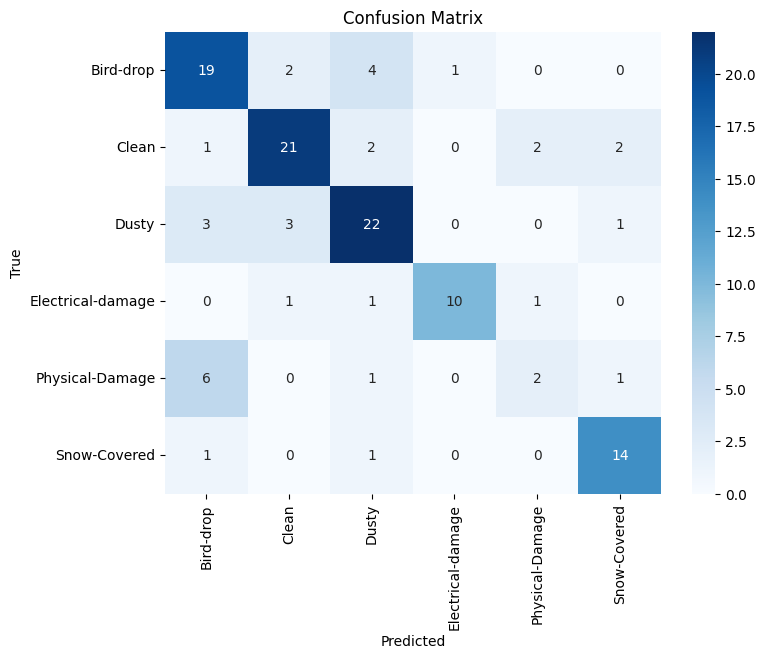

In [8]:
# ===============================================================
# STEP 8: Evaluate Model
# ===============================================================
print("🔎 Evaluating on test data...")
preds = model.predict(X_test)
y_pred = np.argmax(preds, axis=1)
y_true = np.argmax(y_test, axis=1)

acc = np.mean(y_pred == y_true)
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"✅ Test Accuracy: {acc:.4f}")
print(f"✅ Weighted F1-score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [9]:
# ===============================================================
# STEP 9: Save Model & Create Prediction Function
# ===============================================================
model.save("solar_panel_model.h5")
print("💾 Model saved as 'solar_panel_model.h5'.")

def predict_single_image(model_path, image_path, img_size=(224,224), class_names=None):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"❌ File not found: {image_path}")
    
    from tensorflow.keras.models import load_model
    model = load_model(model_path)
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("⚠️ Unable to read image.")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    arr = np.expand_dims(img.astype("float32") / 255.0, 0)
    
    preds = model.predict(arr)[0]
    idx = int(np.argmax(preds))
    conf = float(np.max(preds))
    label = class_names[idx] if class_names else idx
    print(f"✅ Prediction: {label} (Confidence: {conf:.2f})")
    return label, conf



💾 Model saved as 'solar_panel_model.h5'.
